This notebook uses the cleaned/wrangled metadata to continue exploring the Hsiao data. Specifically, the PCA looked kind of weird and I want to know what's up with it!

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

from skbio.diversity import beta_diversity
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

# Read in data

In [2]:
fotu = '../../data/clean/hsiao.dada2_otu_table.txt'
fmeta = '../../data/clean/hsiao.metadata.txt'

df = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

In [3]:
print(df.shape, meta.shape)

((474, 2851), (474, 21))


In [4]:
# Calculate beta diversity
metric = 'braycurtis'
counts = df.astype(int).values
sample_ids = df.index.tolist()

results = beta_diversity(
    metric=metric,
    counts=counts,
    ids=sample_ids)

# PCA on all samples


In [5]:
pca_all = PCA(random_state=12345).fit(results.to_data_frame().values)
ypca_all = pca_all.transform(results.to_data_frame().values)

In [6]:
def make_toplot(ypca, samples, meta):
    """
    Make a dataframe with PC columns from ypca (numpy array).
    Merge meta (dataframe) on 'sample_id' with the samples in samples (list)
    """

    dfpca = pd.DataFrame(data=ypca, 
                         index=samples, 
                         columns=['PC' + str(i) for i in range(1, ypca.shape[1]+1)])
    
    dfpca = pd.merge(dfpca, meta, left_index=True, right_on='sample_id', how='left')

    return dfpca

In [7]:
dfpca_all = make_toplot(ypca_all, sample_ids, meta)
dfpca_all.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,diet_at_time_of_fecal_sample_collection_breast_milk,diet_at_time_of_fecal_sample_collection_formula,diet_at_time_of_fecal_sample_collection_solid_foods,diarrhoea_within_7_days_prior_to_sample_collection,antibiotics_within_7_days_prior_to_sample_collection,medications_antibiotics_and_other,sample_id,disease,raw_day,infection_progression
fecal_sampleid,,,,,,,,,,,,,,,,,,,,,
A.diarrhea.062,1.849497,1.012835,0.438005,0.444596,0.226847,0.522738,-0.454209,-0.319917,0.283175,-0.165698,...,NaN,NaN,NaN,NaN,NaN,NaN,A.diarrhea.062,diarrhea,62.0,0.6019417475728155
Bgsng7052.m26,-2.466575,-0.980531,0.093307,0.269557,0.519894,-0.273175,0.868652,-0.645804,-0.119983,-0.199703,...,Yes,No,Yes,No,No,NaN,Bgsng7052.m26,healthy,NaN,healthy
Bgsng7071.m32,-0.670900,1.228093,-0.165200,0.435669,-0.727463,-0.145395,0.553025,0.136191,0.038543,0.038253,...,Yes,No,Yes,No,No,NaN,Bgsng7071.m32,healthy,NaN,healthy
Bgsng7150.m36,-1.482100,-0.202321,-1.135984,-0.458558,-0.498394,0.410663,0.073262,-0.204143,-0.093217,-0.352476,...,Yes,No,Yes,No,No,Multi Vitamin,Bgsng7150.m36,healthy,NaN,healthy
Bgsng7192.m28,-2.141084,-1.649366,0.048020,-0.252762,0.150071,0.431590,-0.266952,-0.230986,0.175015,0.224965,...,Yes,No,Yes,No,No,NaN,Bgsng7192.m28,healthy,NaN,healthy


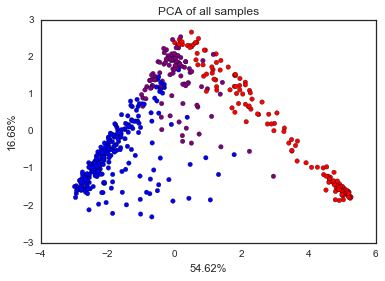

In [8]:
cdict = {'healthy': 'b', 'recovery': 'purple', 'diarrhea': 'r'}
dfpca_all['color'] = dfpca_all['disease'].apply(lambda x: cdict[x])
plt.scatter(dfpca_all['PC1'], dfpca_all['PC2'], c=dfpca_all['color'])
plt.title("PCA of all samples")
plt.xlabel('{:.2f}%'.format(pca_all.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_all.explained_variance_ratio_[1]*100))

Yep, okay still some weird batch effect happening here. Let's zoom in on the diarrhea/recovery samples.

# PCA on the recovery/diarrhea samples (group A)

In [9]:
a_group = meta['group_description'].str.startswith('a')
a_samples = meta.loc[a_group, 'sample_id'].values

pca_agroup = PCA(random_state=12345).fit(results.to_data_frame().loc[a_samples, a_samples].values)
ypca_agroup = pca_agroup.transform(results.to_data_frame().loc[a_samples, a_samples].values)

In [10]:
dfpca_agroup = make_toplot(ypca_agroup, a_samples, meta)

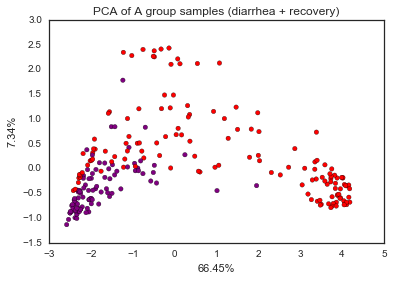

In [11]:
cdict = {'healthy': 'b', 'recovery': 'purple', 'diarrhea': 'r'}
dfpca_agroup['color'] = dfpca_agroup['disease'].apply(lambda x: cdict[x])
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], c=dfpca_agroup['color'])
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))

dark blue = first day of infection, white = last day of infection, red = last day of sampling


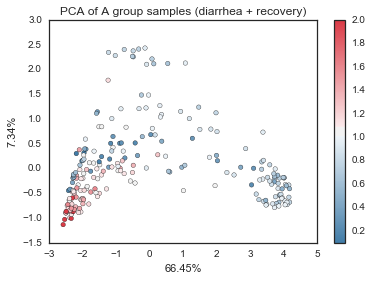

In [12]:
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], 
            c=dfpca_agroup['infection_progression'],
            cmap=sns.diverging_palette(240, 10, as_cmap=True, center='light'))
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))
plt.colorbar()
print('dark blue = first day of infection, white = last day of infection, red = last day of sampling')

dark blue = first day of infection, white = last day of infection, red = last day of sampling


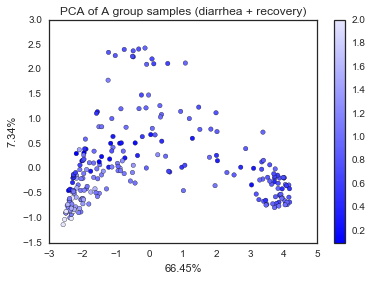

In [13]:
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], 
            c=dfpca_agroup['infection_progression'],
            cmap=sns.light_palette('blue', as_cmap=True, reverse=True))
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))
plt.colorbar()
print('dark blue = first day of infection, white = last day of infection, red = last day of sampling')

Doesn't really look like there's a temporal pattern here, apart from the recovery samples being in the bottom left. Perhaps subject-wise?

In [14]:
cdict = {i:j for i, j in zip(dfpca_agroup['subject_id'].unique(), sns.color_palette("Set1", len(dfpca_agroup['subject_id'].unique())))}
dfpca_agroup['subject_color'] = dfpca_agroup['subject_id'].apply(lambda x: cdict[x])

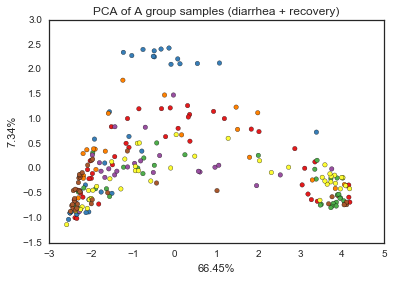

In [15]:
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], 
            c=dfpca_agroup['subject_color'],
            cmap=sns.diverging_palette(240, 10, as_cmap=True))
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))


Nope, not really here either... Why is the PCA plot so funny-shaped then??

Two options moving forward: what features correlate with PC1 (and are they driven by sparsity or something?). Also, if I do PCA within each patient, do I see a temporal trend there?

## What's going on with PC1?

In [16]:
ypca_agroup.shape

(236, 236)

In [17]:
df.loc[a_samples].shape

(236, 2851)

In [18]:
results.to_data_frame().shape

(474, 474)

Oh wait damn you can't do that bc these are PCoA's. Let's make a straight-up Euclidean PCA...?

# Normal PCA (not PCoA)

In [19]:
pca_agroup_euc = PCA(random_state=12345).fit(df.loc[a_samples].values)
ypca_agroup_euc = pca_agroup_euc.transform(df.loc[a_samples].values)

In [20]:
dfpca_agroup_euc = make_toplot(ypca_agroup_euc, a_samples, meta)

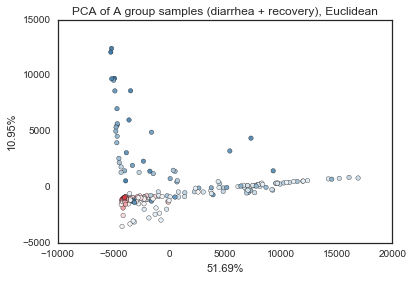

In [21]:
plt.scatter(dfpca_agroup_euc['PC1'], dfpca_agroup_euc['PC2'],
            c=dfpca_agroup['infection_progression'],
            cmap=sns.diverging_palette(240, 10, as_cmap=True, center='light'))
plt.title("PCA of A group samples (diarrhea + recovery), Euclidean")
plt.xlabel('{:.2f}%'.format(pca_agroup_euc.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup_euc.explained_variance_ratio_[1]*100))


Ok this looks super crazy. *Now* what's in PC1?

In [34]:
pca_comps = pd.DataFrame(data=pca_agroup_euc.components_, 
                         index=['PC' + str(i) for i in range(1, pca_agroup_euc.components_.shape[0]+1)],
                         columns=df.columns)
pca_comps.head()

,bbe1b6abd7b8765bdb44601cea259ef0,c90c3a8c4950b89e6e285afa2c05b3e3,ddc7466d073c844eeb86db871e43f205,6bf1a63f1d1b1de9479fb487edb3c077,7e7a16ce216f4ed1d626e25a0f144911,bda9644fa1bec6c0e75cee105e869d42,dac5ca8f20f8291f145c1fd866681218,e6c455846421d3fddd93b1960f78ab08,de4489de0ed2c7a9a8f449164b335fea,e61ce464762adef827e605922b2946e5,...,eeacf6793e9c483cae7f48d295f0cf66,7a38d0bda720a66891722966f63cf6b7,cc9805d9b9ed24f88d0443a69f6029e6,af982c4332b8714c1e48a63ad9588ac7,0a7df920b573f927d17cbd067b9c6fd5,759fe850f2ce516d28a81d9022e64558,fdd1731a9695493c09fd0dac29c57940,19e05c133a36c8fad1b8aae68b8db0e2,29b43dab144ef0ad9c96b826c1af057a,93c8179db48df83d4d5f50e786a4fc3d
PC1,-0.014706,0.986021,-0.100231,0.021693,0.000234,-0.001340,-0.003238,-0.001783,0.000493,-0.000038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PC2,0.083840,0.081554,0.930399,-0.131916,-0.004380,0.010301,0.048667,0.011726,-0.000722,0.001425,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
PC3,-0.016905,0.033543,0.226835,0.245087,0.013382,-0.003639,0.016528,0.000064,0.005550,0.000328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PC4,0.056909,0.025774,-0.135194,-0.127286,-0.000122,0.017861,-0.022618,0.007507,0.000651,-0.000382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PC5,-0.113441,0.003362,-0.125756,-0.028722,-0.000700,0.013347,-0.016906,0.008222,-0.000060,-0.000547,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Let's look at the first few PC's - are they driven predominantly by one or two OTUs? And if so, is there something weird about that OTU?

For the first 3 PC's, plot: the first 20 components, the average abundance across all A group samples, and the median abundance across all A group samples

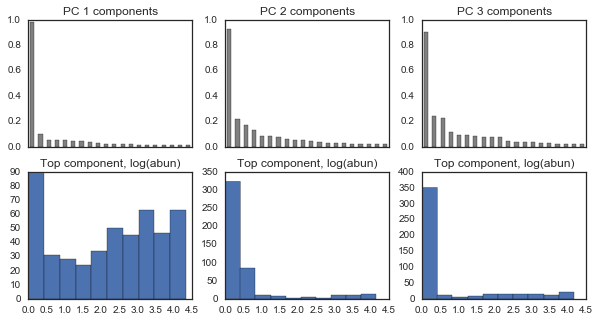

In [58]:
n_pcs = 3

fig, ax = plt.subplots(2, n_pcs, figsize=(10, 5))

for i in range(n_pcs):
    sorted_features = abs(pca_comps.loc['PC' + str(i + 1)]).sort_values(ascending=False)
    # Plot PC contribution
    sorted_features.head(20).plot(kind='bar', ax=ax[0, i], color='gray')
    # Get rid of x labels
    ax[0, i].set_xticklabels('')
    ax[0, i].set_title('PC ' + str(i + 1) + ' components')
    # Plot abundances
    ax[1, i].hist(np.log10(df[sorted_features.index[0]] + 1))
    ax[1, i].set_title('Top component, log(abun)')

So it looks like PC1 is dominated by one OTU that is zero in many people, but ranges up to 10,000 reads in others. Augh I guess I need to map the OTU to taxonomy to see what it is/whether I trust it...? Blerg.

Another option if I end up not trusting this data: normalize each patient to their own recovered abundances. Each person has multiple samples taken after infection, so maybe it would work?